# Model Building

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
data_dir = os.path.join(drive_dir, "Test Data")

Mounted at /content/drive


## 1. Data Preproccesing

### 1.1 Radiomic Features

In [577]:
# load data set
radiomic_feats = pd.read_csv(os.path.join(data_dir, "RadiomicFeatures.csv"))
radiomic_feats.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,0.527583,0.513377,57.283694,111.582079,114.212590,115.152790,73.284082,122.643745,237540.783691,58.868845,...,17.019354,0.011378,489.785185,0.403115,0.658978,136.257830,0.007516,6.080010,0.180107,3255.880190
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.521267,0.446565,45.221860,101.266101,113.592903,100.020486,60.776486,113.771650,164111.006592,52.786691,...,39.427170,0.014237,1231.206019,0.382006,0.641698,130.008726,0.007626,6.319431,0.143800,10372.099039
3,0.565475,0.449311,46.427784,103.331131,113.553247,112.623081,68.007353,115.767666,194060.038535,58.431183,...,26.608202,0.020693,1239.888344,0.433983,0.685239,89.661381,0.013659,5.961805,0.161058,5504.858331
4,0.485448,0.407476,42.413620,104.088690,111.060812,106.570473,58.235949,111.219413,154694.140625,50.529691,...,13.131031,0.015890,1038.289971,0.377286,0.636561,129.422304,0.008716,6.460849,0.150145,4201.871850


In [578]:
# remove rows with all 0s
rad_feats_nomiss = radiomic_feats.loc[~(radiomic_feats==0).all(axis=1)]
rad_feats_nomiss.shape # 6 rows with all missings

(34, 72)

In [579]:
radiomic_feats = rad_feats_nomiss

In [580]:
# remove constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(radiomic_feats)
constant_columns = [column for column in radiomic_feats.columns
                    if column not in radiomic_feats.columns[constant_filter.get_support()]]
radiomic_feats.drop(labels=constant_columns, axis=1, inplace=True)
radiomic_feats.shape # no constant features 

(34, 72)

In [581]:
# remove quasi constant features
qconstant_filter = VarianceThreshold(threshold=0.001)
qconstant_filter.fit(radiomic_feats)
qconstant_columns = [column for column in radiomic_feats.columns
                     if column not in radiomic_feats.columns[qconstant_filter.get_support()]]
radiomic_feats.drop(labels=qconstant_columns, axis=1, inplace=True)
radiomic_feats.shape # 8 quasi-constant features

(34, 64)

In [582]:
# get column names
radiomic_col = list(radiomic_feats.columns)

In [583]:
# z-score standardize predictors
scaler = StandardScaler()
radiomic_feats = scaler.fit_transform(radiomic_feats)

In [584]:
# drop missing columns from full dataset
radiomic_feats = pd.DataFrame(radiomic_feats, columns=radiomic_col)
radiomic_feats.describe()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
count,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,...,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01
mean,-2.612289e-16,-1.959217e-17,7.142979e-17,1.502066e-16,4.898043e-16,-5.779690e-16,-1.436759e-15,-3.787820e-16,3.983741e-16,1.410636e-15,...,5.224579e-17,2.612289e-17,-1.306145e-17,-3.510264e-16,-9.143013e-17,7.183796e-17,-1.502066e-16,-5.120087e-15,4.636814e-16,2.612289e-17
std,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,...,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00
min,-1.148182e+00,-3.260448e+00,-3.473615e+00,-2.336496e+00,-3.170851e+00,-2.511451e+00,-2.174034e+00,-2.594873e+00,-2.621423e+00,-3.823711e+00,...,-4.547636e-01,-4.946716e-01,-4.306893e-01,-1.572193e+00,-2.655322e+00,-2.903951e+00,-1.605182e+00,-1.460971e+00,-2.213877e+00,-4.546963e-01
25%,-5.564567e-01,-2.248139e-01,5.627738e-02,-3.378943e-01,-3.442385e-01,-4.720706e-01,-6.794115e-01,-2.309861e-01,-4.263458e-01,-5.415078e-01,...,-4.288544e-01,-4.403859e-01,-4.173874e-01,-5.546738e-01,-2.033570e-01,-1.488581e-01,-6.367310e-01,-7.575999e-01,-6.112481e-01,-4.288786e-01
50%,-3.462991e-01,6.801638e-02,2.125222e-01,2.870795e-01,2.126530e-01,3.114764e-01,9.258825e-02,1.845624e-01,1.017159e-01,7.326617e-02,...,-3.640228e-01,-3.673394e-01,-3.805225e-01,-2.144922e-01,2.291051e-01,2.613933e-01,-1.149277e-01,-2.613496e-01,7.948599e-02,-3.639258e-01
75%,1.858897e-01,3.174110e-01,4.431269e-01,5.119120e-01,4.972583e-01,4.885192e-01,8.263268e-01,5.547126e-01,6.321590e-01,7.354036e-01,...,-2.704705e-01,-2.642928e-01,-2.520560e-01,4.154065e-01,6.180830e-01,6.069919e-01,3.566234e-01,4.271352e-01,8.499347e-01,-2.707631e-01
max,2.799634e+00,1.988186e+00,1.389265e+00,1.920127e+00,1.644534e+00,2.515668e+00,1.634771e+00,2.676888e+00,1.963715e+00,1.555968e+00,...,3.774310e+00,3.974646e+00,3.399062e+00,3.966781e+00,1.471944e+00,1.335931e+00,2.765209e+00,3.396608e+00,1.646570e+00,3.771671e+00


In [585]:
HCC = np.concatenate((np.zeros(14), np.ones(20)), axis=0)
radiomic_feats['HCC'] = HCC.tolist()

In [576]:
# remove correlated features
def corr_feat(df, outcome, cut = 0.85) :

    # create storage space
    bi_corr = np.zeros((len(df.columns),2))
    df_notarget = df.drop([outcome], axis=1)
    drop = list()
        
    # get correlation matrix and upper triagle
    corr_mtx = df_notarget.corr().abs()
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
  
    # get point biserial correlation with outcome variable
    for idx, column in enumerate(df.columns):
      bi_corr[idx] = stats.pointbiserialr(df[column], df[outcome])
    
    # drop column with p-values
    bi_corr = np.delete(bi_corr, -1, axis=1)

		# loop over correlation matrix and remove features 
    # based on point-biserial correlation with outcome
    for row in range(len(up)-1):
      col_idx = row + 1
      for col in range(col_idx, len(up)):
        if(corr_mtx.iloc[row, col] > cut):
          if(bi_corr[row] > bi_corr[col]): 
            drop.append(row)
          else: 
            drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

In [586]:
# get features that should be dropped
drop_features = corr_feat(radiomic_feats, 'HCC')
len(drop_features) # 37 features removed

<ipython-input-576-ca985805df1b>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))


37

In [587]:
radiomic_feats = radiomic_feats.drop(drop_features, axis=1)
rad_feats_only = radiomic_feats.drop(['HCC'], axis=1)

### 1.2 Deep Features

In [588]:
# load data set
deep_feats = pd.read_csv(os.path.join(data_dir, "DeepFeatures.csv"))
deep_feats.head()

,HCC,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var2039,var2040,var2041,var2042,var2043,var2044,var2045,var2046,var2047,var2048
0,0,0.000000,0.000000,0.606174,0.121180,0.005920,0.243270,0.588090,0.533457,0.125631,...,0.516700,0.059416,0.278842,0.000000,0.589803,0.259552,0.567488,0.065691,0.000000,0.133105
1,0,0.000000,0.000000,0.569489,0.123399,0.044223,0.214921,0.591739,0.460093,0.124388,...,0.446269,0.062793,0.269534,0.000000,0.562928,0.244339,0.556737,0.071345,0.000000,0.136757
2,0,0.000000,0.000000,0.597795,0.124470,0.022407,0.258067,0.621647,0.493019,0.123284,...,0.387516,0.083224,0.272670,0.000000,0.582217,0.265028,0.555296,0.069688,0.000000,0.140291
3,1,0.000042,0.002706,0.563610,0.126187,0.032366,0.203942,0.586207,0.466708,0.127486,...,0.456285,0.059518,0.268479,0.007053,0.557486,0.255491,0.549490,0.079187,0.002157,0.137885
4,1,0.000016,0.000000,0.571508,0.122726,0.021355,0.213375,0.599542,0.464041,0.124101,...,0.430826,0.067377,0.269732,0.000000,0.561884,0.252853,0.557150,0.070767,0.000000,0.133919


In [589]:
# remove rows with all 0s
deep_feats_only = deep_feats.drop(['HCC'], axis=1)
deep_feats_nomiss = deep_feats_only.loc[~(deep_feats_only==0).all(axis=1)]
deep_feats_nomiss.shape # No rows with all missings

(40, 2048)

In [590]:
corr_mtx = pd.concat([deep_feats_nomiss, rad_feats_nomiss], axis=1, keys=['deep', 'rad']).corr().loc['rad', 'deep']

In [591]:
keep = list()

for row in range(len(corr_mtx)):
  for col in range(len(corr_mtx.columns)):
    if(abs(corr_mtx.iloc[row, col]) > 0.4):
      keep.append(col)
    #else: 
      #drop.append(row)

keep_set = list(set(keep))
keepcols_names = list(deep_feats_only.columns[[item for item in keep_set]])

In [592]:
# drop non-correlated features: 1620 features remaining
deep_feats_only = deep_feats_nomiss[keepcols_names]

In [593]:
# remove constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(deep_feats_only)
constant_columns = [column for column in deep_feats_only.columns
                    if column not in deep_feats_only.columns[constant_filter.get_support()]]
deep_feats_only.drop(labels=constant_columns, axis=1, inplace=True)
deep_feats_only.shape # no constant features 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(40, 1620)

In [594]:
# remove quasi-constant features
constant_filter = VarianceThreshold(threshold=0.001)
constant_filter.fit(deep_feats_only)
constant_columns = [column for column in deep_feats_only.columns
                    if column not in deep_feats_only.columns[constant_filter.get_support()]]
deep_feats_only.drop(labels=constant_columns, axis=1, inplace=True)
deep_feats_only.shape # 376 quasi-constant features removed

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(40, 1244)

In [595]:
deep_feats = pd.concat([deep_feats_only.reset_index(drop=True), deep_feats['HCC']], axis=1)

In [596]:
# get features that should be dropped
drop_features = corr_feat(deep_feats, 'HCC')
len(drop_features) # 1242 features removed

<ipython-input-576-ca985805df1b>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))


1242

In [597]:
deep_feats = deep_feats.drop(drop_features, axis=1)
deep_feats_only = deep_feats.drop('HCC', axis=1)

## 2. Exploratory Analysis

In [ ]:
correlations = rad_feats_only.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

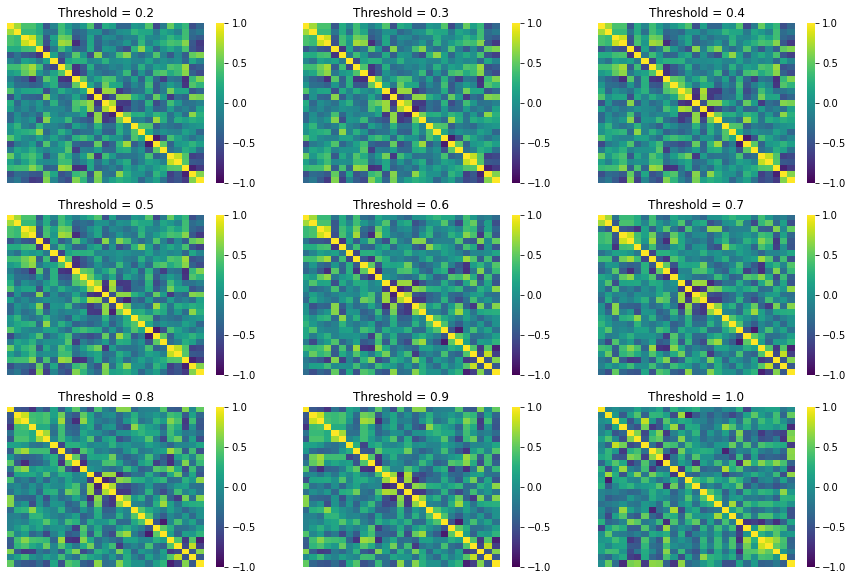

In [ ]:
plt.figure(figsize=(15,10))

for idx, threshold in enumerate(np.arange(0.2,1.1,0.1)):
    
    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)
    
    # Calculate the cluster
    labels = fcluster(Z, threshold, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(features_data.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(features_data[i])
        else:
            df_to_append = pd.DataFrame(features_data[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
            
    # Plot the correlation heatmap
    correlations = clustered.corr()
    sns.heatmap(round(correlations,2), cmap='viridis', vmin=-1, vmax=1, 
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(threshold,2)))


## 3. Model Building

### 3.1 Radiomic Features

In [598]:
# divide data set in 70%:30% split
X = rad_feats_only # Features
y = radiomic_feats['HCC'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [599]:
from sklearn.model_selection import GridSearchCV
param = {'C':np.logspace(-5,5,11), 'penalty':['l1'], 'solver':['liblinear']}
rad_model = LogisticRegression(random_state=123)
rad_model_cv = GridSearchCV(rad_model, param, cv=5, scoring='accuracy')
rad_model_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=123),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='accuracy')

In [600]:
print("tuned hpyerparameters :(best parameters) ",rad_model_cv.best_params_)
print("best score :",rad_model_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10000.0, 'penalty': 'l1', 'solver': 'liblinear'}
best score : 0.79


In [601]:
res = pd.DataFrame(rad_model_cv.cv_results_)
res.iloc[:,res.columns.str.contains("split[0-9]_test_score|params",regex=True)]

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'C': 1e-05, 'penalty': 'l1', 'solver': 'libli...",0.4,0.4,0.4,0.25,0.50
1,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.4,0.4,0.4,0.25,0.50
2,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.4,0.4,0.4,0.25,0.50
3,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.4,0.4,0.4,0.25,0.50
4,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.4,0.4,0.4,0.25,0.50
5,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.6,1.0,0.4,1.00,0.75
6,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.6,0.8,0.4,1.00,0.75
7,"{'C': 100.0, 'penalty': 'l1', 'solver': 'libli...",0.6,0.8,0.6,1.00,0.75
8,"{'C': 1000.0, 'penalty': 'l1', 'solver': 'libl...",0.6,0.8,0.6,1.00,0.75
9,"{'C': 10000.0, 'penalty': 'l1', 'solver': 'lib...",0.6,1.0,0.6,1.00,0.75


In [602]:
#mod = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=16).fit(X_train, y_train)
pred = rad_model_cv.predict(X_test)
rad_model_cv.score(X_test, y_test) # accuracy = 0.82

0.8181818181818182

In [ ]:
# get coefficients
#print(logreg_cv.coef_) # feature 0, 9, 10, 13, and 14 remain

In [603]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, pred)
cnf_matrix

array([[4, 1],
       [1, 5]])

In [604]:
from sklearn.metrics import classification_report

labels = ['no HCC', 'HCC']
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      no HCC       0.80      0.80      0.80         5
         HCC       0.83      0.83      0.83         6

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



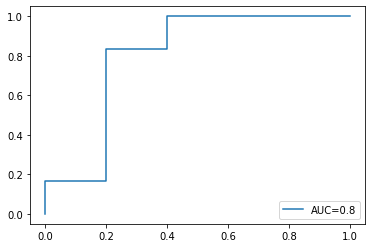

In [605]:
# plot ROC-curve
rad_pred_prob = rad_model_cv.predict_proba(X_test)
rad_fpr, rad_tpr, _ = metrics.roc_curve(y_test, rad_pred_prob[:,1])
rad_auc = metrics.roc_auc_score(y_test, rad_pred_prob[:,1])
plt.plot(rad_fpr,rad_tpr,label="AUC="+str(np.around(rad_auc, decimals=2)))
plt.legend(loc=4)
plt.show()

### 3.2 Deep Features

In [613]:
# divide data set in 70%:30% split
X = deep_feats_only # Features
y = deep_feats['HCC'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [614]:
from sklearn.model_selection import GridSearchCV
param = {'C':np.logspace(-5,5,11), 'penalty':['l1'], 'solver':['liblinear']}
deep_model = LogisticRegression(random_state=123, max_iter=2000)
deep_model_cv = GridSearchCV(deep_model, param, cv=5, scoring='accuracy')
deep_model_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=2000, random_state=123),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='accuracy')

In [615]:
print("tuned hpyerparameters :(best parameters) ", deep_model_cv.best_params_)
print("best score :", deep_model_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
best score : 0.7142857142857143


In [616]:
res = pd.DataFrame(deep_model_cv.cv_results_)
res.iloc[:,res.columns.str.contains("split[0-9]_test_score|params",regex=True)]

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'C': 1e-05, 'penalty': 'l1', 'solver': 'libli...",0.571429,0.571429,0.500000,0.5,0.500000
1,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.571429,0.571429,0.500000,0.5,0.500000
2,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.571429,0.571429,0.500000,0.5,0.500000
3,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.571429,0.571429,0.500000,0.5,0.500000
4,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.571429,0.571429,0.500000,0.5,0.500000
5,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.571429,0.571429,0.500000,0.5,0.500000
6,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.857143,0.714286,0.500000,0.5,0.500000
7,"{'C': 100.0, 'penalty': 'l1', 'solver': 'libli...",0.857143,0.714286,0.666667,0.5,0.833333
8,"{'C': 1000.0, 'penalty': 'l1', 'solver': 'libl...",0.857143,0.714286,0.666667,0.5,0.833333
9,"{'C': 10000.0, 'penalty': 'l1', 'solver': 'lib...",0.857143,0.714286,0.666667,0.5,0.833333


In [617]:
pred = deep_model_cv.predict(X_test)
deep_model_cv.score(X_test, y_test) # accuracy = 0.75

0.75

In [618]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, pred)
cnf_matrix

array([[1, 2],
       [0, 5]])

In [619]:
from sklearn.metrics import classification_report

labels = ['no HCC', 'HCC']
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      no HCC       1.00      0.33      0.50         3
         HCC       0.71      1.00      0.83         5

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8



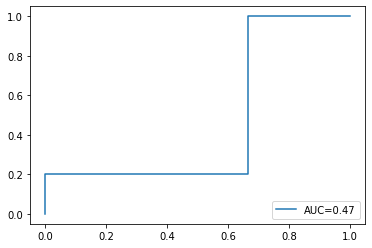

In [620]:
# plot ROC-curve
deep_pred_prob = deep_model_cv.predict_proba(X_test)
deep_fpr, deep_tpr, _ = metrics.roc_curve(y_test, deep_pred_prob[:,1])
deep_auc = metrics.roc_auc_score(y_test, deep_pred_prob[:,1])
plt.plot(deep_fpr,deep_tpr,label="AUC="+str(np.around(deep_auc, decimals=2)))
plt.legend(loc=4)
plt.show()

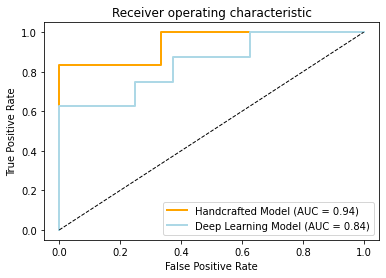

In [531]:
plt.figure()
lw = 2
plt.plot(rad_fpr, rad_tpr,
    color="orange", lw=lw,
    label="Handcrafted Model (AUC = %0.2f)" % rad_auc,
)
plt.plot(deep_fpr, deep_tpr,
    color="lightblue", lw=lw,
    label="Deep Learning Model (AUC = %0.2f)" % deep_auc,
)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [564]:
import statsmodels.api as sm

# get coefficients 
logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit_regularized(alpha=1/100)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6367306149777768
            Iterations: 75
            Function evaluations: 75
            Gradient evaluations: 75


In [565]:
# coefficients are slightly different to sklearn but p-values included
logit_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.119   
Dependent Variable: HCC              AIC:              40.1985 
Date:               2022-12-04 15:37 BIC:              44.1951 
No. Observations:   28               Log-Likelihood:   -17.099 
Df Model:           2                LL-Null:          -19.408 
Df Residuals:       25               LLR p-value:      0.099374
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     75.0000                                    
----------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
var780      4.5472    3.9723   1.1447  0.2523   -3.2384  12.3328
var838     33.2797   33.7436   0.9863  0.3240  -32.8565  99.4159
var1497     0.0000       nan      nan     nan       nan      nan
var1962   -35.0931   31.5339  -1.1129  0.2658  -96.8983  26.7121
===============================================================

"""